In [11]:
import numpy as np
import time,os
np.set_printoptions(linewidth=160)
from lib.ktn_io import *
from lib.gt_tools import *
from scipy.sparse import save_npz,load_npz, diags, eye
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [13]:

data_path = "KTN_data/LJ38/4k/"

# Do we force the generation of the KTN from data, or see if it is in the "cache" 
generate = True

# Do we try a brute solve?
brute = True

# inverse temperature
beta = 8.0

# truncation
Nmax = None#15000



# Load Data

In [14]:

beta, B, K, D, N, u, s, Emin, sel = load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax)#,generate=generate)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s

print("N_states:",N,"N_transitions:",K.data.size)


ValueError: not enough values to unpack (expected 9, got 8)

# Boolean vectors selecting A and/or B regions

In [4]:
B_states, A_states = np.zeros(N,bool), np.zeros(N,bool)
A_states[np.loadtxt(os.path.join(data_path,'min_oct')).astype(int)-1] = True
B_states[np.loadtxt(os.path.join(data_path,'min_ico')).astype(int)-1] = True

basins = B_states + A_states

inter_region = ~basins

names = ["oct","ico"]

print("\n\t%d %s STATES <-> %d %s STATES\n" % (A_states.sum(),names[0],B_states.sum(),names[1]))
print("\n\tbeta:",beta," N_states:",N,"N_rates:",K.data.size,"\n\n")


	5 oct STATES <-> 395 ico STATES


	beta: 4.0  N_states: 11939 N_rates: 61924 




# Graph transformation to remove intermediate states

In [9]:
trmb = 50 # block size


# NB "full_rK" is in fact equal to D-K=(1-B).D in earlier notation - this is done 

rB, rD, full_rK, rN, retry = gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=trmb,retK=True,Ndense=50)


r_A_states = A_states[~inter_region]
r_B_states = B_states[~inter_region]

oneA = np.ones(r_A_states.sum())
oneB = np.ones(r_B_states.sum())
r_BF = BF[~inter_region]

rDSS = D[~inter_region]



# Eigendecomposition of GT matrix and evaluation of $k^{QSD}, k^{SS}, k^{NSS}$

## We also perform same eigendecomposition following additional GT to group all target states

## This is analytically identical, but in practice is numerically beneficial

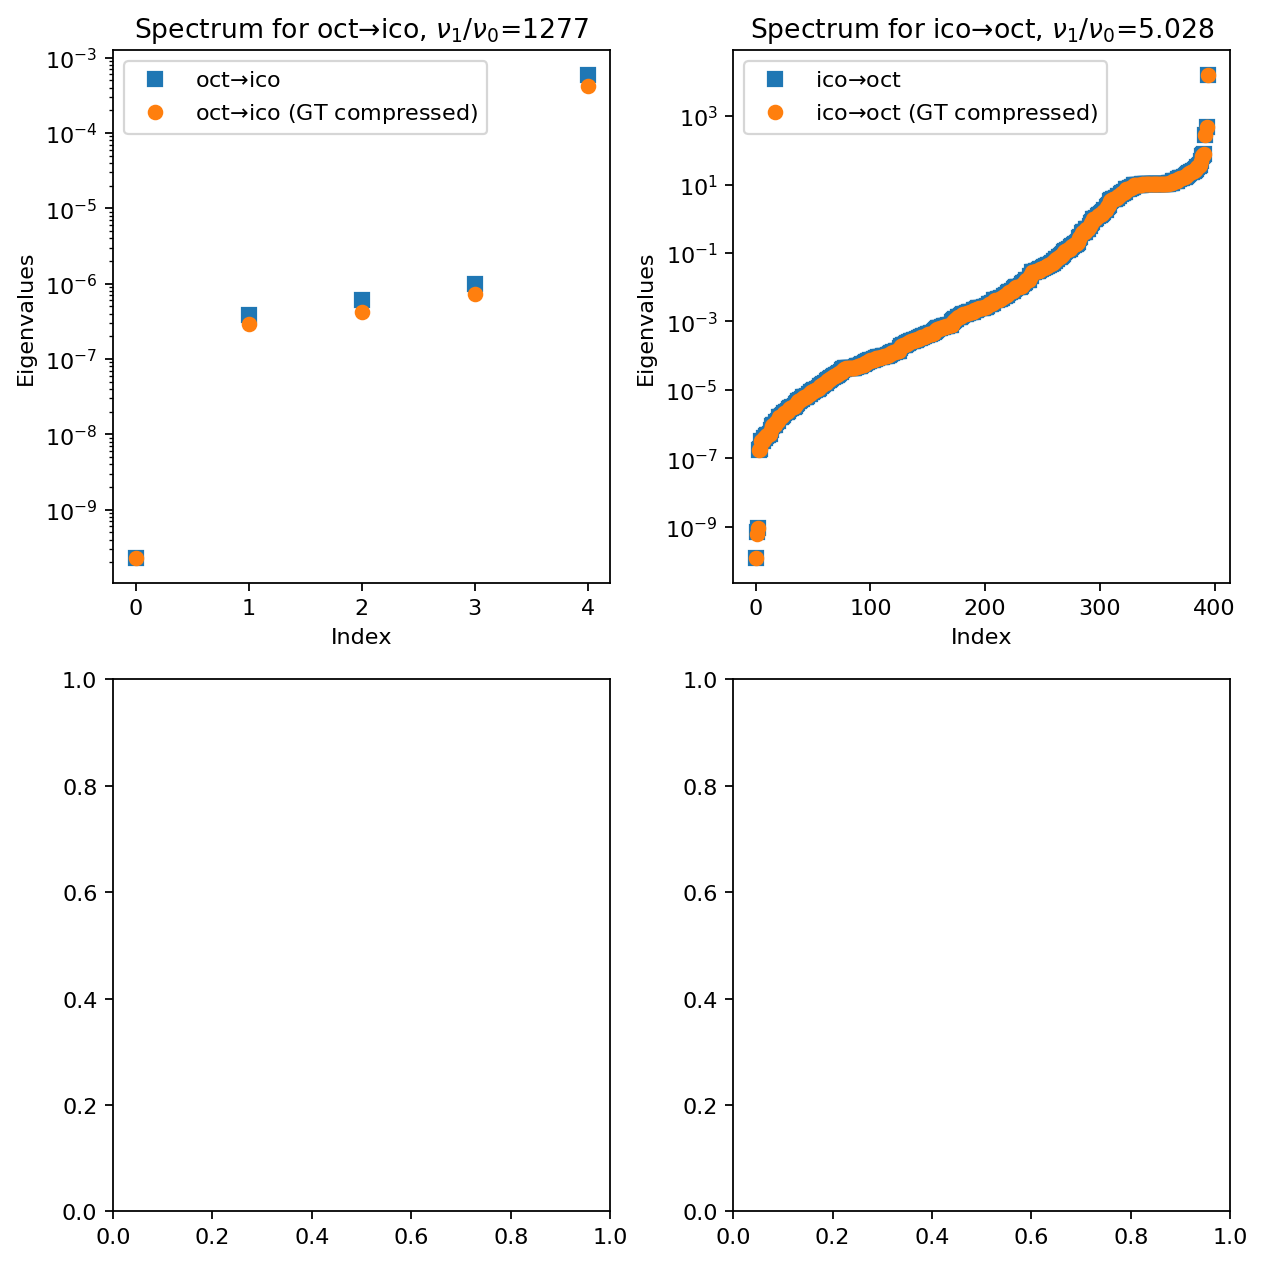

In [16]:
fig,ax = plt.subplots(2,2,figsize=(8,8),dpi=160)

kdata = [] # SS,NSS,QSD,nu

for i, r_s in enumerate([r_A_states,r_B_states]) :
        
    l, v = spla.eig(full_rK[r_s,:][:,r_s].todense())
    
    qsdo = np.abs(l.real).argsort()
    nu = l.real[qsdo]
    
    
    
    
    
    rho = np.exp(-r_BF[r_s])
    rho /= rho.sum()
    
    qsd = v[:,qsdo[0]]
    qsd /= qsd.sum()
    
    
    
    
    
    """
       Further GT compression of final states - differences are due to numerical issues
    """    
    rm_reg = np.zeros(rN,bool)   
    rm_reg[(~r_s).nonzero()[0]] = True
    rm_reg[(~r_s).nonzero()[0][r_BF[~r_s].argmin()]] = False
    
    rrB, rrD, full_rrK, rrN, retry = gt_seq(N=rN,rm_reg=rm_reg,B=rB,D=rD,trmb=1,retK=True,Ndense=1)
    rr_s = r_s[~rm_reg]
    
    rl, rv = spla.eig(full_rrK[rr_s,:][:,rr_s].todense())
    
    rqsdo = np.abs(rl.real).argsort()
    rnu = rl.real[rqsdo]
    
    qsd = rv[:,rqsdo[0]]
    qsd /= qsd.sum()
    
    C = np.ravel(rrB[~rr_s,:][:,rr_s].sum(axis=0))
    
    
    irrK = spla.inv(full_rrK[rr_s,:][:,rr_s].todense())
    tau = irrK.dot(rho).sum(axis=0)
    T_AB = irrK.sum(axis=0)
    k_F = (rho/T_AB).sum()
    
    """
        SS, NSS, QSD, nu, 1.K.qsd, kF, 1/tau
    """
    kSS = C.dot(np.diag(rDSS[r_s])).dot(rho)
    
    kNSS = C.dot(np.diag(rrD[rr_s])).dot(rho)
    
    kQSD = C.dot(np.diag(rrD[rr_s])).dot(qsd)
    
    oneKqsd = (full_rrK[rr_s,:][:,rr_s].dot(qsd)).sum()
    
    kdata.append([kSS,kNSS,kQSD,rnu[0],oneKqsd,k_F,1.0/tau,qsd,rho])
    
    

       
    
    ax[0,i].set_title(r"Spectrum for %s$\to$%s, $\nu_1/\nu_0$=%4.4g" % (names[i],names[1-i],rnu[1]/rnu[0]))
    ax[0,i].set_ylabel("Eigenvalues")
    ax[0,i].set_xlabel("Index")
    ax[0,i].plot(nu,'s',label=r"%s$\to$%s" % (names[i],names[1-i]))
    ax[0,i].plot(rnu,'o',label=r"%s$\to$%s (GT compressed)" % (names[i],names[1-i]))
    ax[0,i].set_yscale("log")
    ax[0,i].legend()
    
    #dp = np.zeros(qdso.size)
    #for ii,oi in enumerate(rqsdo):
    #   dp[ii] = (rl[:,qsdo[ii]]/rl[:,qsdo[ii]].sum() * rho).sum()
    #ax[1,i].plot(np.arange(rdso.size),dp)
    
plt.tight_layout()


# Check for numerical consistency

## We can show analytically that  $\nu_0 \equiv {\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ = "1.K.qsd"

## and also $\nu_0 \equiv {\bf C}^\mathcal{A}_\mathcal{B}\, {\bf D}^\mathcal{I}_\mathcal{B}\, \hat{\pi}^{QSD}_\mathcal{B^I}=k^{QSD}$    =   "k_qsd"

## I find ${\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ is the least reliable

## We also calculate $k^{SS}, k^{NSS}, k^F$ and $k^*=1/\langle\tau\rangle$, but these are not required to equal "kQSD"

## Results clearly show QSD for icosahedral basin is strongly non-Boltzmann ($k^{QSD}\neq k^{NSS}$)



	 oct -> ico

	 nu_0 = 2.25e-10

	 1.K.qsd = 2.25e-10. Error to nu_0 = 2.841e-10%

	 kQSD = 2.25e-10. Error to nu_0 = 1.653e-10%

	 kF = 2.25e-10. Error to nu_0 = -0.008391%

	 k*= 2.25e-10. Error to nu_0 = -0.008563%

	 kSS = 0.0001009. Error to nu_0 = 4.486e+07%

	 kNSS = 1.932e-10. Error to nu_0 = -14.13%

---QSD.max()=0.9998532435, rho.max()=0.9999967538 ------



	 ico -> oct

	 nu_0 = 1.2e-10

	 1.K.qsd = 1.202e-10. Error to nu_0 = 0.1294%

	 kQSD = 1.202e-10. Error to nu_0 = 0.1294%

	 kF = 6.255e-10. Error to nu_0 = 421.2%

	 k*= 6.255e-10. Error to nu_0 = 421.2%

	 kSS = 8.055e-07. Error to nu_0 = 6.711e+05%

	 kNSS = 1.618e-09. Error to nu_0 = 1248%

---QSD.max()=0.807439709, rho.max()=0.4483163757 ------




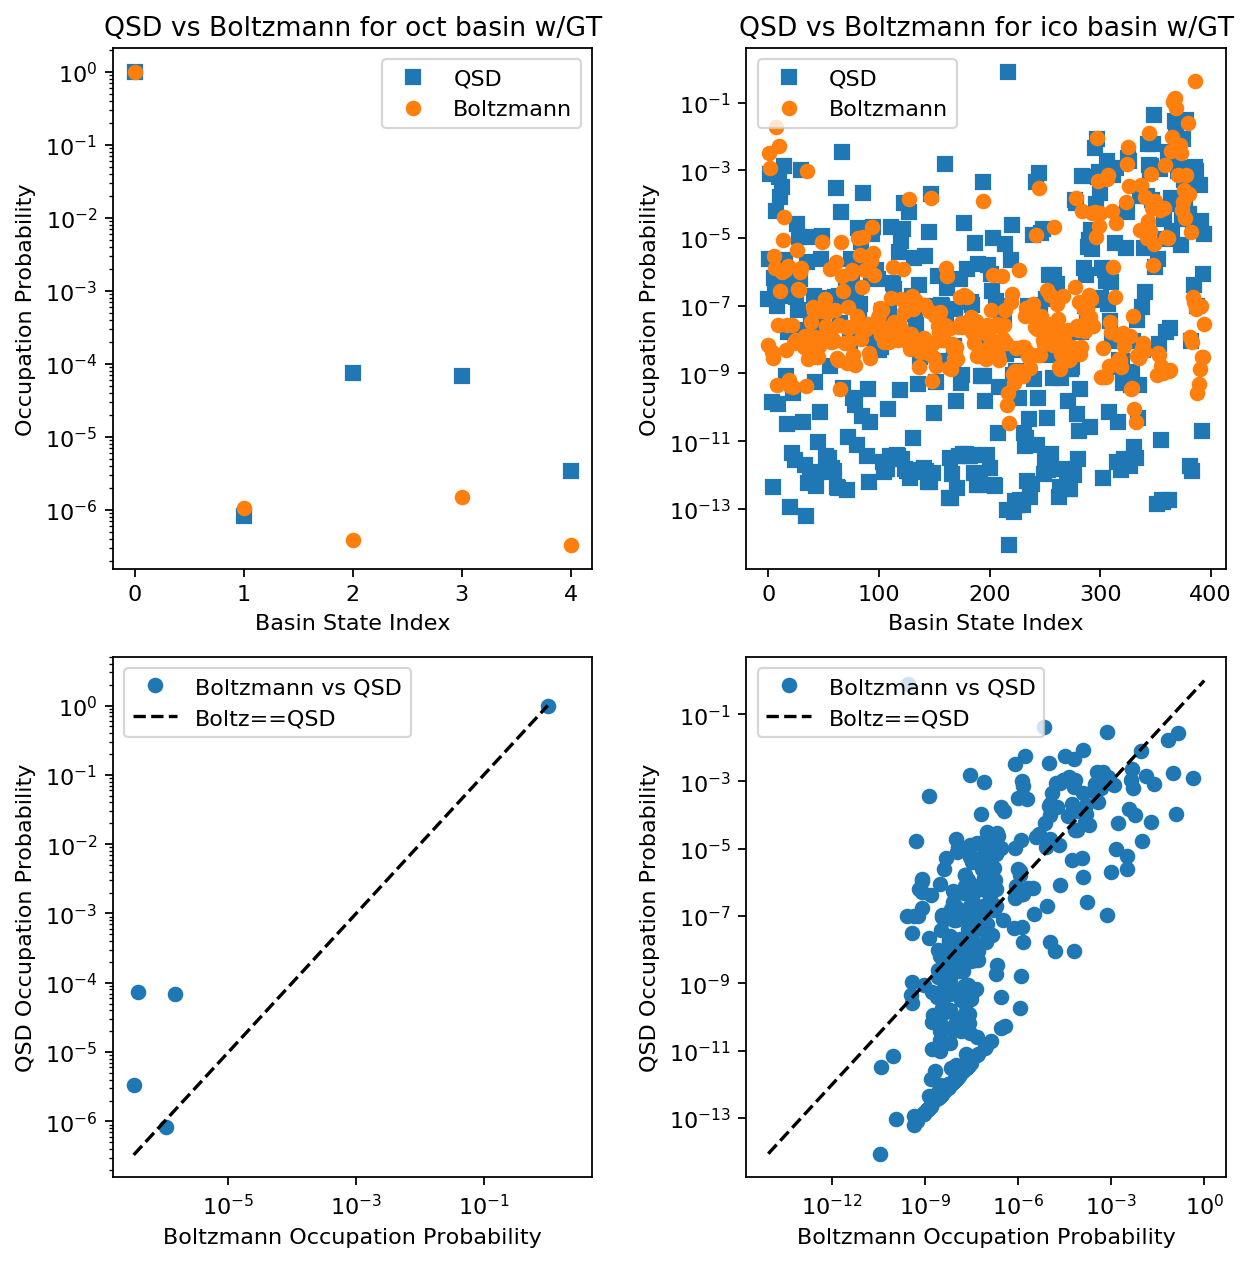

In [11]:
fig,ax = plt.subplots(2,2,figsize=(8,8),dpi=160)

for i in range(2):
    print("\n\t %s -> %s" % (names[i],names[1-i]))
    
    #     0: kSS, 1: kNSS, 2: kQSD, 3: nu, 4: 1.K.qsd, 5: k_F, 6: k* =1.0/tau
    
    print("\n\t nu_0 = %4.4g\n\n\t 1.K.qsd = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][3],kdata[i][4],(kdata[i][4]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kQSD = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][2],(kdata[i][2]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kF = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][5],(kdata[i][5]/kdata[i][3])*100.0-100.0))
    
    print("\n\t k*= %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][6],(kdata[i][6]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][0],(kdata[i][0]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kNSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][1],(kdata[i][1]/kdata[i][3])*100.0-100.0))
    
    print("\n---QSD.max()=%4.10g, rho.max()=%4.10g ------\n\n" % (kdata[i][-2].max(),kdata[i][-1].max()))
    
        
    
    ax[0,i].set_title(r"QSD and Boltzmann for %s basin w/GT" % (names[i]))
    ax[0,i].set_ylabel("Occupation Probability")
    ax[0,i].set_xlabel("Basin State Index")
    ax[0,i].plot(kdata[i][-2],'s',label=r"QSD")
    ax[0,i].plot(kdata[i][-1],'o',label=r"Boltzmann")
    ax[0,i].set_yscale("log")
    ax[0,i].legend()
    
    ax[0,i].set_title(r"QSD vs Boltzmann for %s basin w/GT" % (names[i]))
    ax[1,i].set_xlabel("Boltzmann Occupation Probability")
    ax[1,i].set_ylabel("QSD Occupation Probability")
    ax[1,i].plot(kdata[i][-1],kdata[i][-2],'o',label=r"Boltzmann vs QSD")
    
    pc = np.linspace(min(kdata[i][-2].min(),kdata[i][-1].min()),1.0,10,endpoint=True)
    ax[1,i].plot(pc,pc,'k--',label="Boltz==QSD")
    
    ax[1,i].set_yscale("log")
    ax[1,i].set_xscale("log")
    ax[1,i].set_xlim(xmax=5.0)
    ax[1,i].set_ylim(ymax=5.0)
    
    ax[1,i].legend()
    
plt.tight_layout()